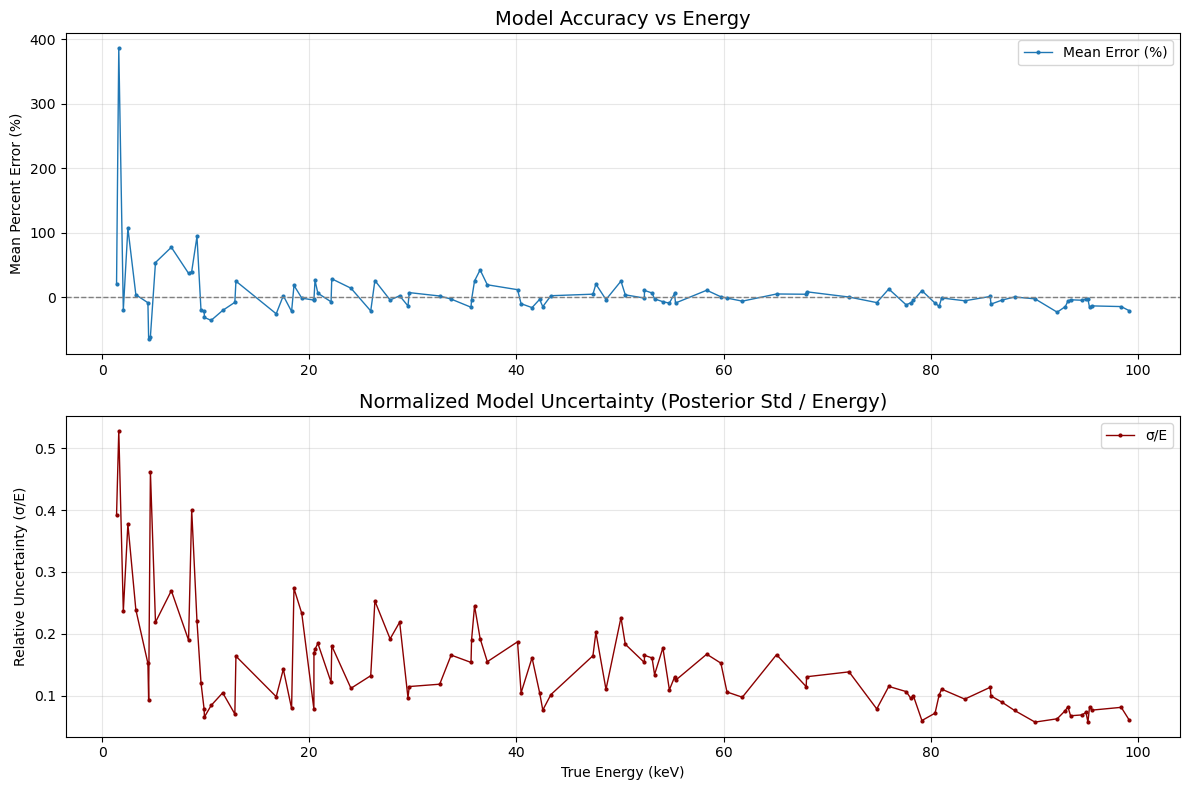

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load results ---
csv_path = "/Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/data/random_eval_results_mnpe2.csv"
df = pd.read_csv(csv_path)

# Filter only successful predictions
df_ok = df[df["status"] == "OK"].copy()

# Compute percent error
df_ok["percent_error"] = 100 * (df_ok["pred_energy_mean"] - df_ok["true_energy"]) / df_ok["true_energy"]

# Aggregate by true energy
agg = df_ok.groupby("true_energy").agg(
    mean_error=("percent_error", "mean"),
    mean_std=("pred_energy_std", "mean"),
    count=("percent_error", "count")
).reset_index().rename(columns={"true_energy": "true_energy_keV"})

# Sort by energy
agg_sorted = agg.sort_values("true_energy_keV")

energies = agg_sorted["true_energy_keV"]
mean_error = agg_sorted["mean_error"]
norm_uncertainty = agg_sorted["mean_std"] / agg_sorted["true_energy_keV"]

# --- Plotting ---
plt.figure(figsize=(12, 8))

# -------- Plot 1: Mean Percent Error -------- #
plt.subplot(2, 1, 1)
plt.plot(energies, mean_error, marker='o', markersize=2, linewidth=1, label="Mean Error (%)")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Model Accuracy vs Energy", fontsize=14)
plt.ylabel("Mean Percent Error (%)")
plt.grid(alpha=0.3)
plt.legend()

# -------- Plot 2: Normalized Uncertainty -------- #
plt.subplot(2, 1, 2)
plt.plot(energies, norm_uncertainty, marker='o', markersize=2, linewidth=1, color="darkred", label="σ/E")
plt.title("Normalized Model Uncertainty (Posterior Std / Energy)", fontsize=14)
plt.xlabel("True Energy (keV)")
plt.ylabel("Relative Uncertainty (σ/E)")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df["percent_error"], bins=25, kde=True, color="steelblue", edgecolor="black")

plt.title("Histogram of Prediction Error Across Random Energies", fontsize=14)
plt.xlabel("Percent Error (%)", fontsize=12)
plt.ylabel("Number of Tracks", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

errors = df['percent_error']
print("Mean error:", np.mean(errors))
print("Std deviation:", np.std(errors))
print("Within ±5%:", np.mean(np.abs(errors) < 5) * 100, "%")
print("Within ±10%:", np.mean(np.abs(errors) < 10) * 100, "%")
print("95th percentile:", np.percentile(np.abs(errors), 95), "%")

KeyError: 'percent_error'

<Figure size 1000x600 with 0 Axes>

----- Z-Score Calibration Stats -----
Mean z-score:        0.272 (ideal = 0)
Std dev z-score:     1.777 (ideal = 1)
Within ±1σ:          56.12% (ideal ≈ 68%)
Within ±2σ:          85.71% (ideal ≈ 95%)
Within ±3σ:          92.86% (ideal ≈ 99.7%)
-------------------------------------


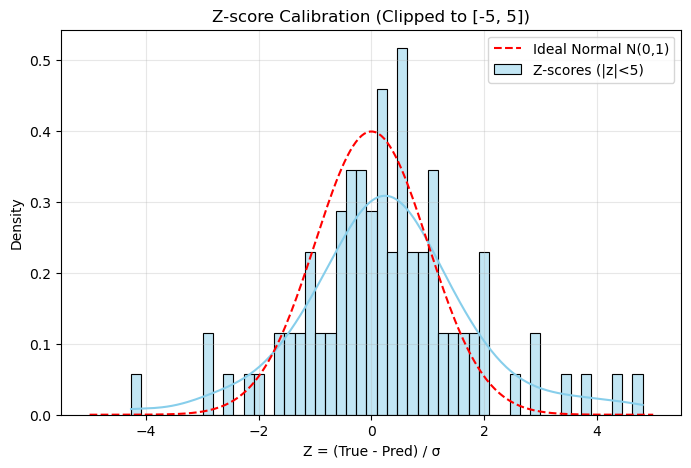

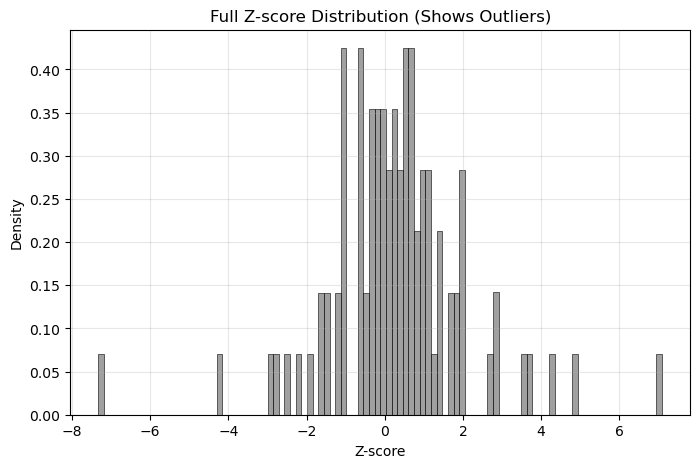

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import pandas as pd

# --- Load your new results CSV ---
csv_path = "/Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/data/random_eval_results_mnpe2.csv"
df = pd.read_csv(csv_path)

# Only keep successful predictions
df = df[df["status"] == "OK"].copy()

# Compute z-score:
# Z = (True - Pred) / PosteriorStd
df["z_score"] = (df["true_energy"] - df["pred_energy_mean"]) / df["pred_energy_std"]

z = df["z_score"].to_numpy()

# Clip extreme z-scores for visualization
z_clipped = z[np.abs(z) < 5]

# --- Calibration stats ---
print("----- Z-Score Calibration Stats -----")
print(f"Mean z-score:        {np.mean(z):.3f} (ideal = 0)")
print(f"Std dev z-score:     {np.std(z):.3f} (ideal = 1)")
print(f"Within ±1σ:          {np.mean(np.abs(z) < 1) * 100:.2f}% (ideal ≈ 68%)")
print(f"Within ±2σ:          {np.mean(np.abs(z) < 2) * 100:.2f}% (ideal ≈ 95%)")
print(f"Within ±3σ:          {np.mean(np.abs(z) < 3) * 100:.2f}% (ideal ≈ 99.7%)")
print("-------------------------------------")

# === Plot #1: Z-scores clipped to [-5,5] ===
plt.figure(figsize=(8, 5))
sns.histplot(z_clipped, bins=50, kde=True, stat="density", color="skyblue", label="Z-scores (|z|<5)")

x = np.linspace(-5, 5, 200)
plt.plot(x, norm.pdf(x), "r--", label="Ideal Normal N(0,1)")

plt.title("Z-score Calibration (Clipped to [-5, 5])")
plt.xlabel("Z = (True - Pred) / σ")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# === Plot #2: Full Z-score distribution (includes outliers) ===
plt.figure(figsize=(8, 5))
sns.histplot(z, bins=100, stat="density", color="gray")

plt.title("Full Z-score Distribution (Shows Outliers)")
plt.xlabel("Z-score")
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.show()

In [16]:
df["abs_error"] = np.abs(df["percent_error"])
energy_bins = pd.cut(df["true_energy_keV"], bins=np.linspace(0, 100, 11))  # 0–100 keV in 10 bins

bin_summary = df.groupby(energy_bins).agg({
    "percent_error": ["mean", "std"],
    "abs_error": ["mean", "median"],
    "posterior_std_keV": "mean"
})

print(bin_summary)

                percent_error             abs_error             \
                         mean        std       mean     median   
true_energy_keV                                                  
(0.0, 10.0]         -0.051337  16.780399  13.018860  10.738697   
(10.0, 20.0]         3.421470  13.247267  10.454897   8.625451   
(20.0, 30.0]         3.149956  13.155936  10.447778   8.511109   
(30.0, 40.0]         2.993041  12.355537   9.871383   7.952485   
(40.0, 50.0]         2.410134  11.783064   9.455221   7.861010   
(50.0, 60.0]         1.821192  11.600961   9.171970   7.385583   
(60.0, 70.0]         1.266110  11.327383   8.990734   7.482687   
(70.0, 80.0]         0.439145  10.194907   8.055227   6.756318   
(80.0, 90.0]        -1.515697   8.381380   6.513960   5.178600   
(90.0, 100.0]       -5.078346   6.442281   5.962122   4.291389   

                posterior_std_keV  
                             mean  
true_energy_keV                    
(0.0, 10.0]              1.491136

/var/folders/wv/wqt6hj5j10x18q4_x16rqnvc0000gn/T/ipykernel_13067/859921241.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = df.groupby(energy_bins).agg({


In [38]:
import pandas as pd
import numpy as np

# 1. Filter by energy range
E_min, E_max = 0,100
df_range = df[(df["true_energy_keV"] >= E_min) & (df["true_energy_keV"] <= E_max)]

# 2. Errors
percent_errors = df_range["percent_error"].values
abs_keV_errors = df_range["posterior_mean_keV"] - df_range["true_energy_keV"]
abs_keV_errors = abs_keV_errors.values

# 3. Summary stats
summary = {
    "Mean Percent Error (%)": np.mean(percent_errors),
    "Median Percent Error (%)": np.median(percent_errors),
    "Mean Absolute Percent Error (%)": np.mean(np.abs(percent_errors)),
    # ✅ New metrics (keV-space)
    "Mean Absolute Error (keV)": np.mean(np.abs(abs_keV_errors)),
    "Median Absolute Error (keV)": np.median(np.abs(abs_keV_errors)),
}

# 4. Format and Print
summary_df = pd.DataFrame(summary, index=[f"{E_min}-{E_max} keV"]).T
summary_df.columns = ["Value"]
summary_df["Value"] = pd.to_numeric(summary_df["Value"], errors="coerce").round(3)

print(f"\nEnergy Range: {E_min}–{E_max} keV")
print(summary_df)


Energy Range: 0–100 keV
                                 Value
Mean Percent Error (%)           0.996
Median Percent Error (%)         0.491
Mean Absolute Percent Error (%)  9.123
Mean Absolute Error (keV)        4.079
Median Absolute Error (keV)      2.856


In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
plt.title("Histogram of Percent Error")
plt.xlabel("Percent Error (%)")
plt.ylabel("Number of Tracks")
plt.grid(alpha=0.3)
plt.show()

NameError: name 'errors' is not defined

<Figure size 800x500 with 0 Axes>